In [29]:
import os
import numpy as np
import pandas as pd
import scipy.stats as st
import wandb
import matplotlib.pyplot as plt
from typing import Literal
from dotenv import load_dotenv

wandb_api_key = load_dotenv("../../.env", override=True)
wandb.login(key=os.getenv("WANDB_API_KEY"))


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/billy/.netrc


True

In [28]:
def get_metrics_dict(
    df : pd.DataFrame, 
    run_notes : list,
    metrics_dict : dict,
    convert_m_to_cm : bool=True,
    verbose : bool=False,
    use_average : Literal['mean_std', 'median_iqr'] = 'mean_std'
    ) -> dict:
    notes_dict = {notes : metrics_dict.copy() for notes in run_notes}
    for notes in run_notes:
        # get each fold this notes was pretrained using the synthetic data
        notes_df = df.loc[df['Notes'] == notes]
        if notes_df.shape[0] != 5:
            if verbose:
                print(f'notes_df.shape[0] != 5 for notes {notes}, actual shape: {notes_df.shape}')
                print('getting 5 most recent runs')
            notes_df = notes_df.sort_values(by='Created', ascending=False).head(5)
            
        for metric in metrics_dict.keys():
            metric_values = notes_df[metric].values
            if verbose:
                print(f'{notes} {metric} {metric_values}')
            if convert_m_to_cm and ('mean_RMSE' in metric or 'mean_MAE' in metric):
                # convert from m^{-1} to cm^{-1}
                metric_values = metric_values * 1e-2
            # calculate mean and std or median and iqr
            if use_average == 'mean_std':
                notes_dict[notes][metric] = [np.mean(metric_values), np.std(metric_values)]
            elif use_average == 'median_iqr':
                median = np.median(metric_values)
                q1 = np.percentile(metric_values, 25)
                q3 = np.percentile(metric_values, 75)
                iqr = q3 - q1
                notes_dict[notes][metric] = [median, iqr]
    return notes_dict

In [3]:
def print_single_tex_reslts_table(models_dict : dict, caption : str,
                                  label : str, metric_headers : str) -> None:
    metrics = list(list(models_dict.values())[0].keys())
    models = list(models_dict.keys())
    tex_table_string = f"""\\begin{{table*}}
    \\centering
    \\caption{caption}
    \\setlength{{\\tabcolsep}}{{3pt}}
    %\\begin{{tabular}}{{|p{{25pt}}|p{{75pt}}|p{{115pt}}|}}
    \\begin{{tabular}}{{|l|l|l|l|l|l|l|}}
    \\hline
    Model & """ + metric_headers + """ \\\\
    \\hline"""
    for model in models:
        row_name = '{' + model.replace('_',' ') + '}'
        tex_table_string += f"""\\multirow{{2}}{{*}}{row_name} & ${models_dict[model][metrics[0]][0]:.3f}$"""
        for metric in metrics[1:]:
            tex_table_string += f""" & ${models_dict[model][metric][0]:.3f}$"""
        tex_table_string += f""" \\\\ \n"""
        for metric in metrics:
            tex_table_string += f""" & $\\pm{models_dict[model][metric][1]:.3f}$"""
        tex_table_string += f""" \\\\ 
        \\hline"""
    tex_table_string += f"""\\end{{tabular}}
    \\label{label}
    \\end{{table*}}
    
    """
    
    print(tex_table_string)

In [4]:
def print_double_tex_reslts_table(models_dict_left : dict, header_left : str,
                                  models_dict_right : dict, header_right : str,
                                  caption : str, label : str, metric_headers : str,
                                  header_len : str='{3}') -> None:
    metrics_left = list(list(models_dict_left.values())[0].keys())
    metrics_right = list(list(models_dict_right.values())[0].keys())
    models = list(models_dict_left.keys()) # both dicts must have the same models
    tex_table_string = f"""\\begin{{table*}}
    \\centering
    \\caption{caption}
    \\label{{table}}
    \\setlength{{\\tabcolsep}}{{3pt}}
    %\\begin{{tabular}}{{|p{{25pt}}|p{{75pt}}|p{{115pt}}|}}
    \\resizebox{{\\textwidth}}{{!}}""" + """{""" + f"""\\begin{{tabular}}""" + """{{|l|"""

    for i in range(2*int(header_len[1])):
        tex_table_string += f"""l|"""
    tex_table_string += """}}"""
    
    tex_table_string += f"""
    \\hline
    \\multirow{{2}}{{*}}{{Model}} & \\multicolumn{header_len}{{|l|}}{header_left} & \\multicolumn{header_len}{{|l|}}{header_right} \\\\
    \\cline{{2-{str(int(header_len[1])*2+1)}}}
    & """ + metric_headers + """ & """ + metric_headers + """ \\\\
    \\hline"""
    for model in models:
        row_name = '{' + model.replace('_',' ') + '}'
        tex_table_string += f"""\\multirow{{2}}{{*}}{row_name} & ${models_dict_left[model][metrics_left[0]][0]:.3f}$"""
        for metric in metrics_left[1:]:
            tex_table_string += f""" & ${models_dict_left[model][metric][0]:.3f}$"""
        tex_table_string += f"""\n"""
        for metric in metrics_right:
            tex_table_string += f""" & ${models_dict_right[model][metric][0]:.3f}$"""
        tex_table_string += f""" \\\\ \n"""
        for metric in metrics_left:
            tex_table_string += f""" & $\\pm{models_dict_left[model][metric][1]:.3f}$"""
        tex_table_string += f"""\n"""
        for metric in metrics_right:
            tex_table_string += f""" & $\\pm{models_dict_right[model][metric][1]:.3f}$"""
        tex_table_string += f""" \\\\ 
        \\hline"""
    tex_table_string += f"""\\end{{tabular}}""" + """}""" + f"""
    \\label{label}
    \\end{{table*}}
    
    """
    
    print(tex_table_string)

In [ ]:
if __name__ == "__main__":
    # wandb.login() not needed - credentials stored in ~/.netrc from terminal login
    api = wandb.Api(timeout=6000)

    # Optional: Filter by tags, state, etc. (see W&B API docs)
    FILTER = {}  # You can use {"state": "finished"} to get only completed runs

    # Project is specified by <entity/project-name>
    runs = api.runs("aisurrey_photoacoustics/MSOT_EDM2", filters=FILTER)


In [20]:
if __name__ == "__main__":
    run_notes = [
        'e2eQPAT_Janeks_weights',
        'experimental_from_scratch_UNet_e2eQPAT',
        'experimental_from_scratch_UNet_e2eQPAT_fixedseed',
        'experimental_from_scratch_UNet_e2eQPAT_fixedseed_9bd6c0b',
        'e2eQPAT_fine_tune',
        'e2eQPAT_fine_tune_no_shuffle',
        'e2eQPAT_boft3_fine_tune',
        'e2eQPAT_fine_tune_lr1em5_l2reg1em1',
        'e2eQPAT_fine_tune_lr1em5',
        'experimental_from_scratch_UNet_diffusion_ablation',
        'experimental_from_scratch_UNet_diffusion_ablation_deeperunet',
        'experimental_from_scratch_UNet_diffusion_ablation_ema',
        'experimental_from_scratch_UNet_wl_pos_emb',
        'EDM2_fine_tune',
        'EDM2_fine_tune_lr1em3',
        'EDM2_fine_tune_lr1em2_l2reg1em1',
        'EDM2_fine_tune_lr1em3_l2reg1em1',
        'experimental_from_scratch_EDM2',
    ]
    
    run_dict_list = []
    history_dict = {}
    for run in runs:
        
        if run.notes not in run_notes:
            continue

        if run.notes not in (history_dict.keys()):
            history_dict[run.notes] = {}

        history_dict[run.notes][run.name] = {'mean_train_loss' : run.history(
            x_axis='_step', keys=['mean_train_loss'], stream='default', pandas=True
        )}
        history_dict[run.notes][run.name]['mean_experimental_val_loss'] = run.history(
            x_axis='_step', keys=['mean_experimental_val_loss'], stream='default', pandas=True,
        )

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        run_dict_list.append(run.summary._json_dict)
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        run_dict_list[-1].update(
            {k: v for k,v in run.config.items() if not k.startswith('_')}
        )
        # .name is the human-readable name of the run.
        run_dict_list[-1]['Name'] = run.name
        run_dict_list[-1]['Notes'] = run.notes
        run_dict_list[-1]['Created'] = run.createdAt
        
    df = pd.DataFrame(run_dict_list)

    # Preview the result
    print(df.head())

    columns = df.columns.values

        _runtime   _step    _timestamp               _wandb  \
0  127283.197837  361533  1.763706e+09  {'runtime': 127283}   
1  128089.871350  361533  1.763708e+09  {'runtime': 128090}   
2  129843.934592  361533  1.763711e+09  {'runtime': 129844}   
3  129263.980979  361533  1.763712e+09  {'runtime': 129264}   
4  127540.831311  361533  1.763781e+09  {'runtime': 127541}   

   bg_experimental_test_mean_MAE  bg_experimental_test_mean_PSNR  \
0                       0.044191                        4.912240   
1                       0.031130                        4.226144   
2                       0.030113                        6.131927   
3                       0.031268                        5.874666   
4                       0.031749                        4.777763   

  bg_experimental_test_mean_R2  bg_experimental_test_mean_RMSE  \
0                    -Infinity                        0.073382   
1                    -Infinity                        0.077458   
2             

In [21]:
if __name__ == "__main__":
    api = wandb.Api()

    # Optional: Filter by tags, state, etc. (see W&B API docs)
    FILTER = {}  # You can use {"state": "finished"} to get only completed runs

    # Project is specified by <entity/project-name>
    runs = api.runs("aisurrey_photoacoustics/MSOT_Diffusion", filters=FILTER)

    notes = [
        'experimental_from_scratch_UNet_e2eQPAT_fixedseed_9bd6c0b',
        'e2eQPAT_fine_tune_and_pretained_with_amsgrad_lr1em4_eps1em8',
    ]

    run_dict_list = []
    for run in runs:
        if run.notes not in notes:
            continue

        if run.notes not in (history_dict.keys()):
            history_dict[run.notes] = {}

        history_dict[run.notes][run.name] = {'mean_train_loss' : run.history(
            x_axis='_step', keys=['mean_train_loss'], stream='default', pandas=True
        )}
        history_dict[run.notes][run.name]['mean_experimental_val_loss'] = run.history(
            x_axis='_step', keys=['mean_experimental_val_loss'], stream='default', pandas=True,
        )

        # .summary contains the output keys/values for metrics like accuracy.
        #  We call ._json_dict to omit large files
        run_dict_list.append(run.summary._json_dict)
        # .config contains the hyperparameters.
        #  We remove special values that start with _.
        run_dict_list[-1].update(
            {k: v for k,v in run.config.items() if not k.startswith('_')}
        )
        # .name is the human-readable name of the run.
        run_dict_list[-1]['Name'] = run.name
        run_dict_list[-1]['Notes'] = run.notes
        run_dict_list[-1]['Created'] = run.createdAt
        
    df = pd.concat([df, pd.DataFrame(run_dict_list)], ignore_index=True)

    # Preview the result
    print(df.head())

    columns = df.columns.values

        _runtime   _step    _timestamp               _wandb  \
0  127283.197837  361533  1.763706e+09  {'runtime': 127283}   
1  128089.871350  361533  1.763708e+09  {'runtime': 128090}   
2  129843.934592  361533  1.763711e+09  {'runtime': 129844}   
3  129263.980979  361533  1.763712e+09  {'runtime': 129264}   
4  127540.831311  361533  1.763781e+09  {'runtime': 127541}   

   bg_experimental_test_mean_MAE  bg_experimental_test_mean_PSNR  \
0                       0.044191                        4.912240   
1                       0.031130                        4.226144   
2                       0.030113                        6.131927   
3                       0.031268                        5.874666   
4                       0.031749                        4.777763   

  bg_experimental_test_mean_R2  bg_experimental_test_mean_RMSE  \
0                    -Infinity                        0.073382   
1                    -Infinity                        0.077458   
2             

In [ ]:
# results for experimental test dataset
if __name__ == "__main__":
    run_notes = [
        'e2eQPAT_Janeks_weights',
        'experimental_from_scratch_UNet_e2eQPAT',
        'experimental_from_scratch_UNet_e2eQPAT_fixedseed',
        'experimental_from_scratch_UNet_e2eQPAT_fixedseed_9bd6c0b',
        'e2eQPAT_fine_tune_and_pretained_with_amsgrad_lr1em4_eps1em8',
        'e2eQPAT_fine_tune',
        'e2eQPAT_fine_tune_no_shuffle',
        'e2eQPAT_boft3_fine_tune',
        'e2eQPAT_fine_tune_lr1em5_l2reg1em1',
        'e2eQPAT_fine_tune_lr1em5',
        'experimental_from_scratch_UNet_diffusion_ablation',
        'experimental_from_scratch_UNet_diffusion_ablation_deeperunet',
        'experimental_from_scratch_UNet_diffusion_ablation_ema',
        'experimental_from_scratch_UNet_wl_pos_emb',
        'EDM2_fine_tune',
        'EDM2_fine_tune_lr1em3',
        'EDM2_fine_tune_lr1em2_l2reg1em1',
        'EDM2_fine_tune_lr1em3_l2reg1em1',
        'experimental_from_scratch_EDM2',
    ]
    inclusion_metrics_dict = {
        'inclusion_experimental_test_mean_RMSE' : [None]*5,
        'inclusion_experimental_test_mean_Rel_Err' : [None]*5,
        'inclusion_experimental_test_mean_PSNR' : [None]*5,
    }
    bg_metrics_dict = {
        'bg_experimental_test_mean_RMSE' : [None]*5,
        'bg_experimental_test_mean_Rel_Err' : [None]*5,
        'bg_experimental_test_mean_PSNR' : [None]*5,
    }    
    metric_headers = """RMSE (cm$^{{-1}}$) & Rel. Error (\\%) & PSNR"""

    bg_metrics_models_dict = get_metrics_dict(
        df, run_notes, bg_metrics_dict, convert_m_to_cm=False, use_average='median_iqr'
    )
    
    inclusion_metrics_models_dict = get_metrics_dict(
        df, run_notes, inclusion_metrics_dict, convert_m_to_cm=False, use_average='median_iqr'
    )

    print_double_tex_reslts_table(
        bg_metrics_models_dict,
        '{Background}',
        inclusion_metrics_models_dict, 
        '{Inclusions}',
        #'{Experimental test dataset. Mean and standard deviation of 5 runs.}',
        '{Experimental test dataset. Median and interquartile range of 5 runs.}',
        '{tab:experimental_test_metrics}',
        metric_headers
    )

\begin{table*}
    \centering
    \caption{Experimental test dataset. Median and interquartile range of 5 runs.}
    \label{table}
    \setlength{\tabcolsep}{3pt}
    %\begin{tabular}{|p{25pt}|p{75pt}|p{115pt}|}
    \resizebox{\textwidth}{!}{\begin{tabular}{{|l|l|l|l|l|l|l|}}
    \hline
    \multirow{2}{*}{Model} & \multicolumn{3}{|l|}{Background} & \multicolumn{3}{|l|}{Inclusions} \\
    \cline{2-7}
    & RMSE (cm$^{{-1}}$) & Rel. Error (\%) & PSNR & RMSE (cm$^{{-1}}$) & Rel. Error (\%) & PSNR \\
    \hline\multirow{2}{*}{e2eQPAT Janeks weights} & $0.094$ & $49.488$ & $1.743$
 & $0.719$ & $34.126$ & $8.872$ \\ 
 & $\pm0.010$ & $\pm2.836$ & $\pm0.809$
 & $\pm0.027$ & $\pm0.950$ & $\pm0.203$ \\ 
        \hline\multirow{2}{*}{experimental from scratch UNet e2eQPAT} & $0.095$ & $51.095$ & $1.660$
 & $0.689$ & $33.202$ & $8.971$ \\ 
 & $\pm0.013$ & $\pm5.445$ & $\pm0.848$
 & $\pm0.058$ & $\pm5.074$ & $\pm1.165$ \\ 
        \hline\multirow{2}{*}{experimental from scratch UNet e2eQPAT fixeds

In [ ]:
# results for pretraining on imagenet synthetic dataset
if __name__ == "__main__":
    run_notes = [
        'pretrain_UNet_e2eQPAT',
        'pretrain_UNet_e2eQPAT_fixedseed',
        'pretrain_EDM2',
        'pretrain_UNet_wl_pos_emb',
        'pretrain_UNet_diffusion_ablation',
    ]
    bg_metrics_dict = {
        'bg_synthetic_test_mean_RMSE' : [None]*5,
        'bg_synthetic_test_mean_Rel_Err' : [None]*5,
        'bg_synthetic_test_mean_PSNR' : [None]*5,
    }    
    metric_headers = """RMSE (cm$^{{-1}}$) & Rel. Error (\\%) & PSNR"""

    bg_metrics_models_dict = get_metrics_dict(
        df, run_notes, bg_metrics_dict, convert_m_to_cm=False
    )
    
    print_single_tex_reslts_table(
        bg_metrics_models_dict,
        '{Synthetic test dataset. Mean and standard deviation of 5 runs.}',
        '{tab:imagenet_test_metrics}',
        metric_headers
    )

\begin{table*}
    \centering
    \caption{Synthetic test dataset. Mean and standard deviation of 5 runs.}
    \setlength{\tabcolsep}{3pt}
    %\begin{tabular}{|p{25pt}|p{75pt}|p{115pt}|}
    \begin{tabular}{|l|l|l|l|l|l|l|}
    \hline
    Model & RMSE (cm$^{{-1}}$) & Rel. Error (\%) & PSNR \\
    \hline\multirow{2}{*}{pretrain UNet e2eQPAT} & $5.299$ & $13.677$ & $21.548$ \\ 
 & $\pm0.077$ & $\pm0.520$ & $\pm0.161$ \\ 
        \hline\multirow{2}{*}{pretrain UNet e2eQPAT fixedseed} & $5.265$ & $13.512$ & $21.617$ \\ 
 & $\pm0.126$ & $\pm0.401$ & $\pm0.211$ \\ 
        \hline\multirow{2}{*}{pretrain EDM2} & $3.121$ & $7.737$ & $26.648$ \\ 
 & $\pm0.072$ & $\pm0.160$ & $\pm0.130$ \\ 
        \hline\multirow{2}{*}{pretrain UNet wl pos emb} & $4.668$ & $11.590$ & $22.688$ \\ 
 & $\pm0.058$ & $\pm0.293$ & $\pm0.113$ \\ 
        \hline\multirow{2}{*}{pretrain UNet diffusion ablation} & $4.232$ & $10.429$ & $23.641$ \\ 
 & $\pm0.083$ & $\pm0.161$ & $\pm0.114$ \\ 
        \hline\end{tabular}
 

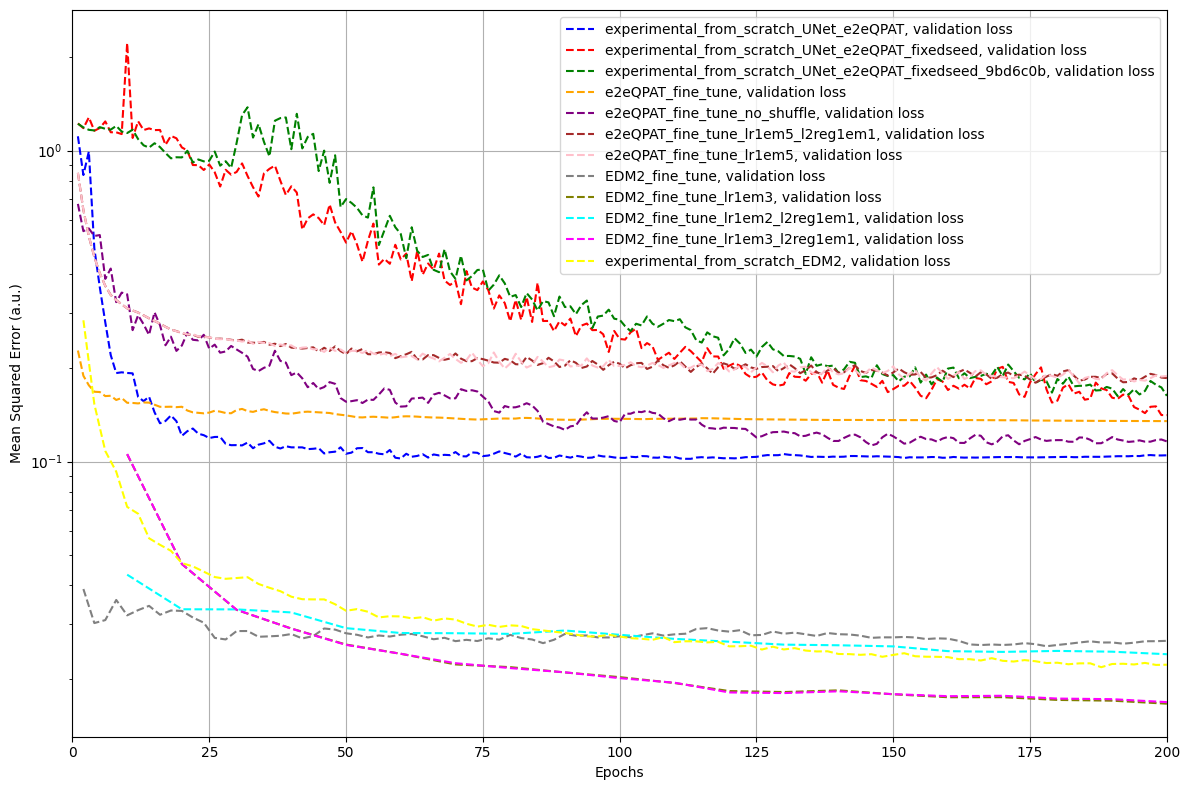

In [23]:
import matplotlib.pyplot as plt

run_notes = [
    #'e2eQPAT_Janeks_weights', # no loss curves for pretrained weights
    'experimental_from_scratch_UNet_e2eQPAT',
    'experimental_from_scratch_UNet_e2eQPAT_fixedseed',
    'experimental_from_scratch_UNet_e2eQPAT_fixedseed_9bd6c0b',
    'e2eQPAT_fine_tune',
    'e2eQPAT_fine_tune_no_shuffle',
    #'e2eQPAT_boft3_fine_tune',
    'e2eQPAT_fine_tune_lr1em5_l2reg1em1',
    'e2eQPAT_fine_tune_lr1em5',
    # 'experimental_from_scratch_UNet_diffusion_ablation',
    # 'experimental_from_scratch_UNet_diffusion_ablation_deeperunet',
    # 'experimental_from_scratch_UNet_diffusion_ablation_ema',
    # 'experimental_from_scratch_UNet_wl_pos_emb',
    'EDM2_fine_tune',
    'EDM2_fine_tune_lr1em3',
    'EDM2_fine_tune_lr1em2_l2reg1em1',
    'EDM2_fine_tune_lr1em3_l2reg1em1',
    'experimental_from_scratch_EDM2',
]

epochs = 200
separate_ax_for_labels = True

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
ax.set_yscale('log')
ax.set_ylabel(r'Mean Squared Error (a.u.)')
#ax.set_xlabel('Steps')
ax.set_xlabel('Epochs')

colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'pink', 'gray', 'olive', 'cyan', 'magenta', 'yellow', 'teal']
#lines = ['-', '--', '-.', ':']
if __name__ == "__main__":
    for i, notes in enumerate(run_notes):
        notes_history = history_dict[notes]
        for j, fold in enumerate(['fold0', 'fold1', 'fold2', 'fold3', 'fold4']):
            for key in list(notes_history.keys()):
                if fold in key:
                    notes_fold_history = notes_history[key]
                    break
            
            if fold == 'fold0':
                val_loss_steps = notes_fold_history['mean_experimental_val_loss']['_step'].values
                val_loss_steps = val_loss_steps * epochs / np.max(val_loss_steps)

                train_loss_steps = train_loss_steps = notes_fold_history['mean_train_loss']['_step'].values
                train_loss_steps = train_loss_steps * epochs / np.max(train_loss_steps)
            
                train_loss = np.zeros((5, len(train_loss_steps)), dtype=np.float32)
                val_loss = np.zeros((5, len(val_loss_steps)), dtype=np.float32)

            train_loss[j] = notes_fold_history['mean_train_loss']['mean_train_loss'].values
            val_loss[j] = notes_fold_history['mean_experimental_val_loss']['mean_experimental_val_loss'].values
                    
        #ax.plot(train_loss_steps, train_loss.mean(axis=0), color=colors[i], linestyle='-', label=f'{notes} train loss')
        ax.plot(val_loss_steps, val_loss.mean(axis=0), color=colors[i], linestyle='--', label=f'{notes}, validation loss')
        # fill between min and max for train and val loss
        #ax.fill_between(train_loss_steps, train_loss.min(axis=0), train_loss.max(axis=0), color=colors[i], alpha=0.2)
        #ax.fill_between(val_loss_steps, val_loss.min(axis=0), val_loss.max(axis=0), color=colors[i], alpha=0.2)
        
    ax.legend(loc='upper right')
    ax.set_xlim(0, epochs)
    ax.grid(True)
    ax.set_axisbelow(True)
    fig.tight_layout()

    fig.savefig('loss_curves.png')
    fig.savefig('loss_curves.svg')